In [1]:
library(tidyverse)
library(rpart) 

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



https://www.rdocumentation.org/packages/randomForest/versions/4.6-14/topics/randomForest

OOB error

https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html

In [17]:
install.packages('randomForest')
library(randomForest)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin




In [3]:
# data_url <- getURL(
data <- read.csv('https://raw.githubusercontent.com/TimS-ml/DataMining/master/0_TakeHome/0x01_conversion_project.csv')

# Eda

In [4]:
head(data)

,country,age,new_user,source,total_pages_visited,converted
,<chr>,<int>,<int>,<chr>,<int>,<int>
1,UK,25,1,Ads,1,0
2,US,23,1,Seo,5,0
3,US,28,1,Seo,4,0
4,China,39,1,Seo,5,0
5,US,30,1,Seo,6,0
6,US,31,0,Seo,1,0


In [5]:
str(data)

'data.frame':	316200 obs. of  6 variables:
 $ country            : chr  "UK" "US" "US" "China" ...
 $ age                : int  25 23 28 39 30 31 27 23 29 25 ...
 $ new_user           : int  1 1 1 1 1 0 1 0 0 0 ...
 $ source             : chr  "Ads" "Seo" "Seo" "Seo" ...
 $ total_pages_visited: int  1 5 4 5 6 1 4 4 4 2 ...
 $ converted          : int  0 0 0 0 0 0 0 0 0 0 ...


Identify the wrong data
- Probably a US site
- Young user base
- Max age is 123 years! Doesn't make scence

In [6]:
summary(data)

   country               age            new_user         source         
 Length:316200      Min.   : 17.00   Min.   :0.0000   Length:316200     
 Class :character   1st Qu.: 24.00   1st Qu.:0.0000   Class :character  
 Mode  :character   Median : 30.00   Median :1.0000   Mode  :character  
                    Mean   : 30.57   Mean   :0.6855                     
                    3rd Qu.: 36.00   3rd Qu.:1.0000                     
                    Max.   :123.00   Max.   :1.0000                     
 total_pages_visited   converted      
 Min.   : 1.000      Min.   :0.00000  
 1st Qu.: 2.000      1st Qu.:0.00000  
 Median : 4.000      Median :0.00000  
 Mean   : 4.873      Mean   :0.03226  
 3rd Qu.: 7.000      3rd Qu.:0.00000  
 Max.   :29.000      Max.   :1.00000  

In [7]:
sort(unique(data$age), decreasing=TRUE)

[1] 123 111  79  77  73  72  70  69  68  67  66  65  64  63  62  61  60  59  58
[20]  57  56  55  54  53  52  51  50  49  48  47  46  45  44  43  42  41  40  39
[39]  38  37  36  35  34  33  32  31  30  29  28  27  26  25  24  23  22  21  20
[58]  19  18  17

Preview outliers

In [8]:
subset(data, age>79)

,country,age,new_user,source,total_pages_visited,converted
,<chr>,<int>,<int>,<chr>,<int>,<int>
90929,Germany,123,0,Seo,15,1
295582,UK,111,0,Ads,10,1


In [9]:
data = subset(data, age<80)

## Visualization of different countries

`summarise()` ungrouping output (override with `.groups` argument)



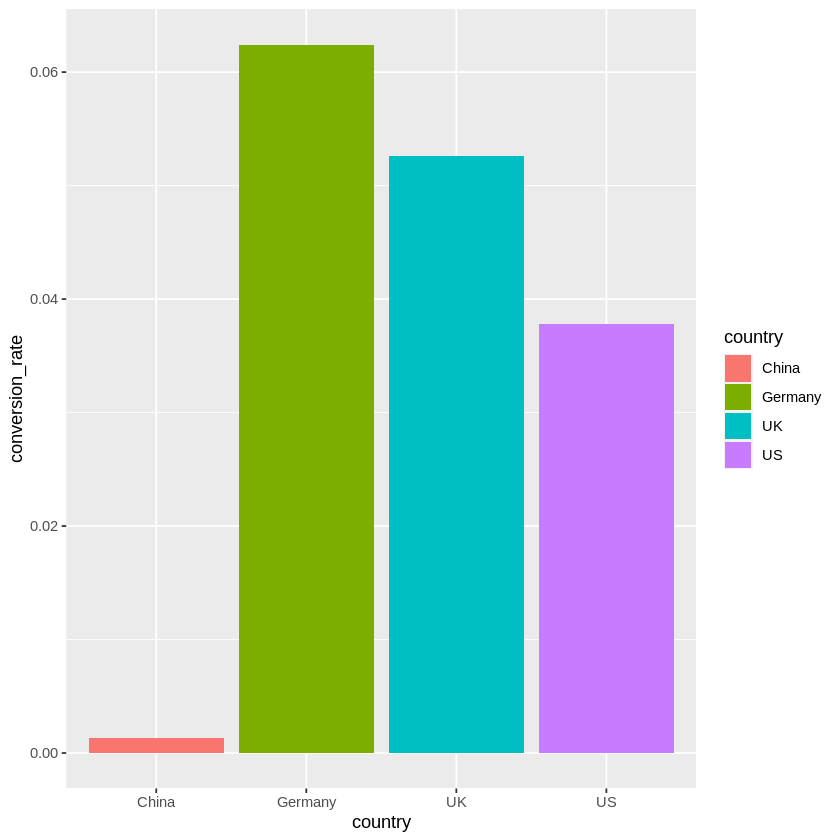

In [10]:
data_country = data %>%
    group_by(country) %>%
    summarise(conversion_rate = mean(converted))

ggplot(data=data_country, aes(x=country, y=conversion_rate)) +
    geom_bar(stat='identity', aes(fill=country))

Spending more time on the site -> higher probability of conversion

`summarise()` ungrouping output (override with `.groups` argument)



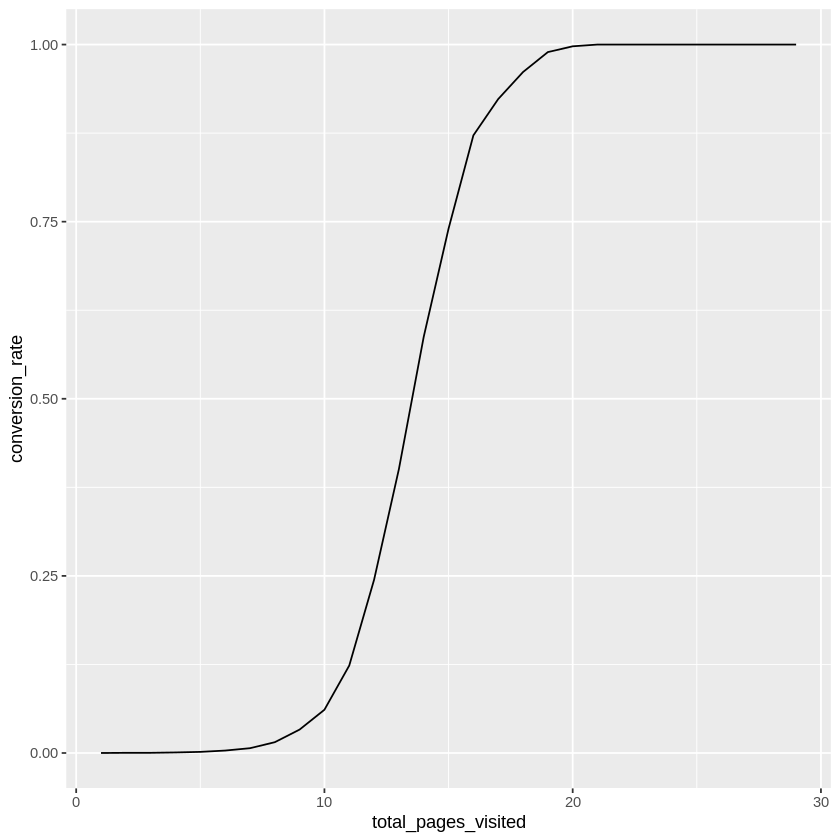

In [11]:
data_pages = data %>%
    group_by(total_pages_visited) %>%
    summarise(conversion_rate = mean(converted))
qplot(total_pages_visited, conversion_rate, data=data_pages, geom='line')

# Machine Learning

In [14]:
data$converted = as.factor(data$converted)  # let's make the class a factor
data$new_user = as.factor(data$new_user)  # also this a factor
levels(data$country)[levels(data$country)=="Germany"]="DE" # Shorter name, easier to plot.

Train / test split

In [15]:
train_sample = sample(nrow(data), size = nrow(data)*0.66) 
train_data = data[train_sample,] 
test_data = data[-train_sample,] 

OOB Error

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/77/OOB_Error_Example.png/1024px-OOB_Error_Example.png">

In [18]:
rf = randomForest(
    y = train_data$converted, 
    x = train_data[, -ncol(train_data)], 
    ytest = test_data$converted, 
    xtest = test_data[, -ncol(test_data)], 
    ntree = 100, 
    mtry = 3, 
    keep.forest = TRUE) 

Variable importance

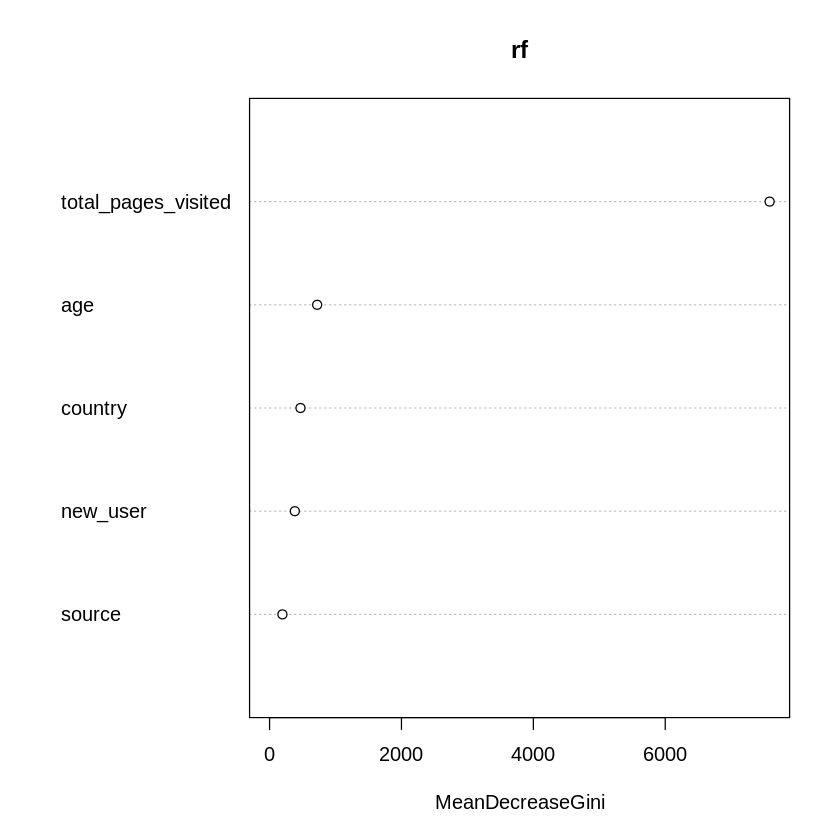

In [19]:
varImpPlot(rf, type=2)

Rebuild RF without that `total_pages_visited` variable

Since classes are heavily unbalanced and we don’t have that very powerful variable anymore, let’s change the weight a bit, just to make sure we will get something classified as 1.

In [24]:
rf = randomForest(
    y = train_data$converted, 
    x = train_data[, -c(5, ncol(train_data))],  # 5: total page visited
    ytest = test_data$converted, 
    xtest = test_data[, -c(5, ncol(train_data))], 
    ntree = 100, 
    mtry = 3, 
    keep.forest = TRUE,
    classwt = c(0.7,0.3))

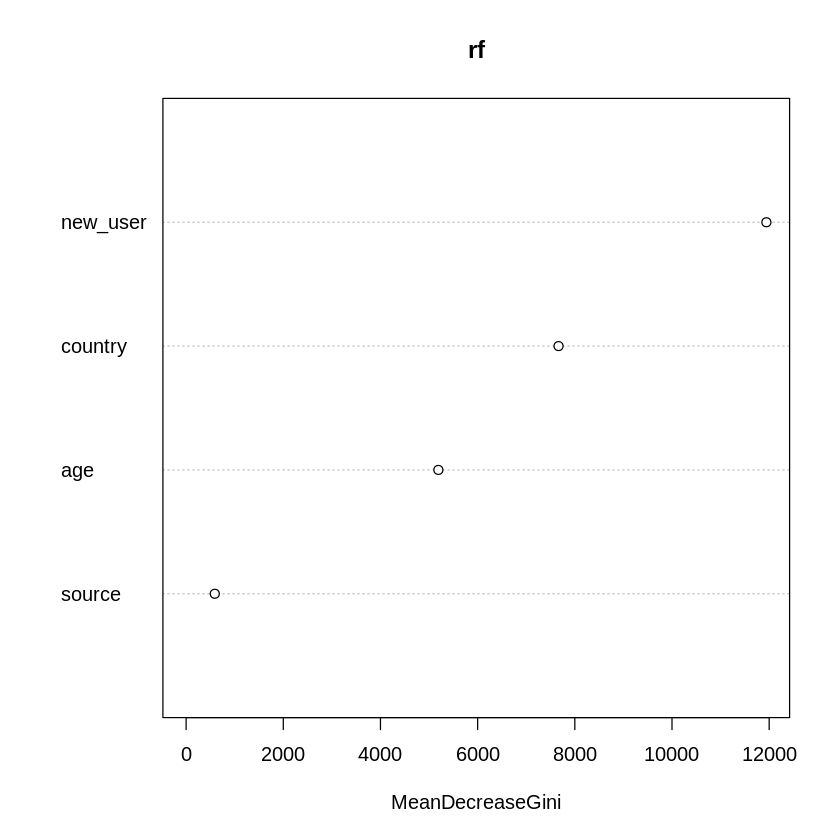

In [21]:
varImpPlot(rf, type=2)

# Partial dependence polts for most important 4 variables

We just care about the trend, not the actual y value

In [25]:
# op <- par(mfrow=c(2, 2)) 
# partialPlot(rf, train_data, country, 1) 
# partialPlot(rf, train_data, age, 1) 
# partialPlot(rf, train_data, new_user, 1) 
# partialPlot(rf, train_data, source, 1)

Warning message in seq.default(min(xv), max(xv), length = n.pt):
“NAs introduced by coercion”


ERROR: ignored

rpart:
Recursive Partitioning And Regression Trees

https://www.rdocumentation.org/packages/rpart/versions/4.1-15/topics/rpart

In [23]:
tree = rpart(
    data$converted ~ ., 
    data[, -c(5, ncol(data))], 
    control = rpart.control(maxdepth = 3), 
    parms = list(prior = c(0.7, 0.3))) 
tree

n= 316198 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 316198 94859.4000 0 (0.70000000 0.30000000)  
   2) new_user=1 216744 28268.0600 0 (0.84540048 0.15459952) *
   3) new_user=0 99454 66591.3400 0 (0.50063101 0.49936899)  
     6) country=China 23094   613.9165 0 (0.96445336 0.03554664) *
     7) country=Germany,UK,US 76360 50102.8100 1 (0.43162227 0.56837773)  
      14) age>=29.5 38341 19589.5200 0 (0.57227507 0.42772493) *
      15) age< 29.5 38019 23893.0000 1 (0.33996429 0.66003571) *

As you can see, conclusions usually end up being about:
1. tell marketing to get more of the good performing user segments
2. tell product to fix the experience for the bad performing ones